In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from scipy import stats
from scipy.stats import zscore

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

# Part A

• **DOMAIN**: Automobile

• **CONTEXT**: The data concerns city-cycle fuel consumption in miles per gallon to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.

• **DATA DESCRIPTION**:
1. **cylinders**: multi-valued discrete
2. **displacement**: continuous
3. **horsepower**: continuous
4. **weight**: continuous
5. **mpg**: continuous
6. **acceleration**: continuous
7. **model year**: multi-valued discrete
8. **origin**: multi-valued discrete
9. **car name**: string (unique for each instance)

• **PROJECT OBJECTIVE**: To understand K-means Clustering by applying on the Car Dataset to segment the cars into various categories.

• **STEPS AND TASK**

#### 1. Data Understanding & Exploration:

##### A. Read ‘Car name.csv’ as a DataFrame and assign it to a variable.

In [2]:
data1 = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/4. Unsupervised Learning/Part1+-+Car+name.csv')

print('Shape of 1st Dataframe', data1.shape)

data1.head()

Shape of 1st Dataframe (398, 1)


,car_name
0,chevrolet chevelle malibu
1,buick skylark 320
2,plymouth satellite
3,amc rebel sst
4,ford torino


##### B. Read ‘Car-Attributes.json as a DataFrame and assign it to a variable.

In [3]:
data2 = pd.read_json('D:/Nikhila/PGP - AIML/2. Projects/4. Unsupervised Learning/Part1+-+Car-Attributes.json')

print('Shape of 2nd Dataframe', data2.shape)

data2.head()

Shape of 2nd Dataframe (398, 8)


,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


##### C. Merge both the DataFrames together to form a single DataFrame

We will use **join()** - Using this approach, the column to be added ("car_name") from 1st dataframe to the 2nd dataframe is first extracted.

In [4]:
#Here the extracted column has been assigned to a variable.
extracted_col = data1['car_name']

#The column is added to the 2nd dataframe using join() function. 
data = data2.join(extracted_col)

print('Shape of the Dataframe', data.shape)

data.head()

Shape of the Dataframe (398, 9)


,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


##### D. Print 5 point summary of the numerical features and share insights.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


Column 'hp' is stored as object.Hence we cannot see the 5 point summary.

**5-point summary**

**1) min** - Minimum value in the column (Example: 9 is the min value in "mpg" column)

**2) 25%** - Analyzes 25th Percentile (Example: 25% of the data is less than 17.5	in "mpg" column)

**3) 50%** - Identifies the centre of a data set. (Example: Median value is 23 in "mpg" column)

**4) 75%** - Analyzes 75th Percentile (Example: 75% of the data is less than 29	in "mpg" column)

**5) max** -  Maximum value in the column (Example: 46.6 is the max value in "mpg" column)

**Observation** -

1) Mean and Median values are approximately same for - 'mpg', 'acc', 'yr', 'origin' - i.e, **Data is Normally distributed**.

2) We have difference between the 75% value and max value,- 'disp', 'wt' indicating **skewness in the data**.

3) Mean > median. Therefore the distribution is **skewed to the right**.



--------------------------------

#### 2. Data Preparation & Analysis:

##### H. Check for unexpected values in all the features and datapoints with such values.

[‘?’ is present in ‘hp’]

In [6]:
unexp_val = pd.DataFrame(data.hp.str.isdigit()) 
unexp_val[unexp_val['hp'] == False]

,hp
32,False
126,False
330,False
336,False
354,False
374,False


In [7]:
#All entries with '?' are replaced with nan and converted to float datatype
data['hp']=data['hp'].replace('?',np.nan)
data['hp'] = data['hp'].astype('float64')

##### A. Check and print feature-wise percentage of missing values present in the data and impute with the best suitable approach.

In [8]:
#creating a dataframe with sum of missing values
missing_val = pd.DataFrame(data.isnull().sum())

#Rename the column as missing_percentage.
missing_val = missing_val.rename(columns = {0: 'Missing_percentage'})

#Calculating in terms of percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(data))*100

#Arranging in descending order.
missing_val = missing_val.sort_values('Missing_percentage', ascending = False)

missing_val

,Missing_percentage
hp,1.507538
mpg,0.000000
cyl,0.000000
disp,0.000000
wt,0.000000
acc,0.000000
yr,0.000000
origin,0.000000
car_name,0.000000


**Observation** - We will replace missing values in 'hp' with median

In [9]:
data['hp']=data['hp'].fillna(data['hp'].median())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mpg       398 non-null    float64
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    float64
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   origin    398 non-null    int64  
 8   car_name  398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


##### B. Check for duplicate values in the data and impute with the best suitable approach.

In [10]:
data.duplicated().sum()

0

**Observation** - There are no duplicate values

##### C. Plot a pairplot for all features.

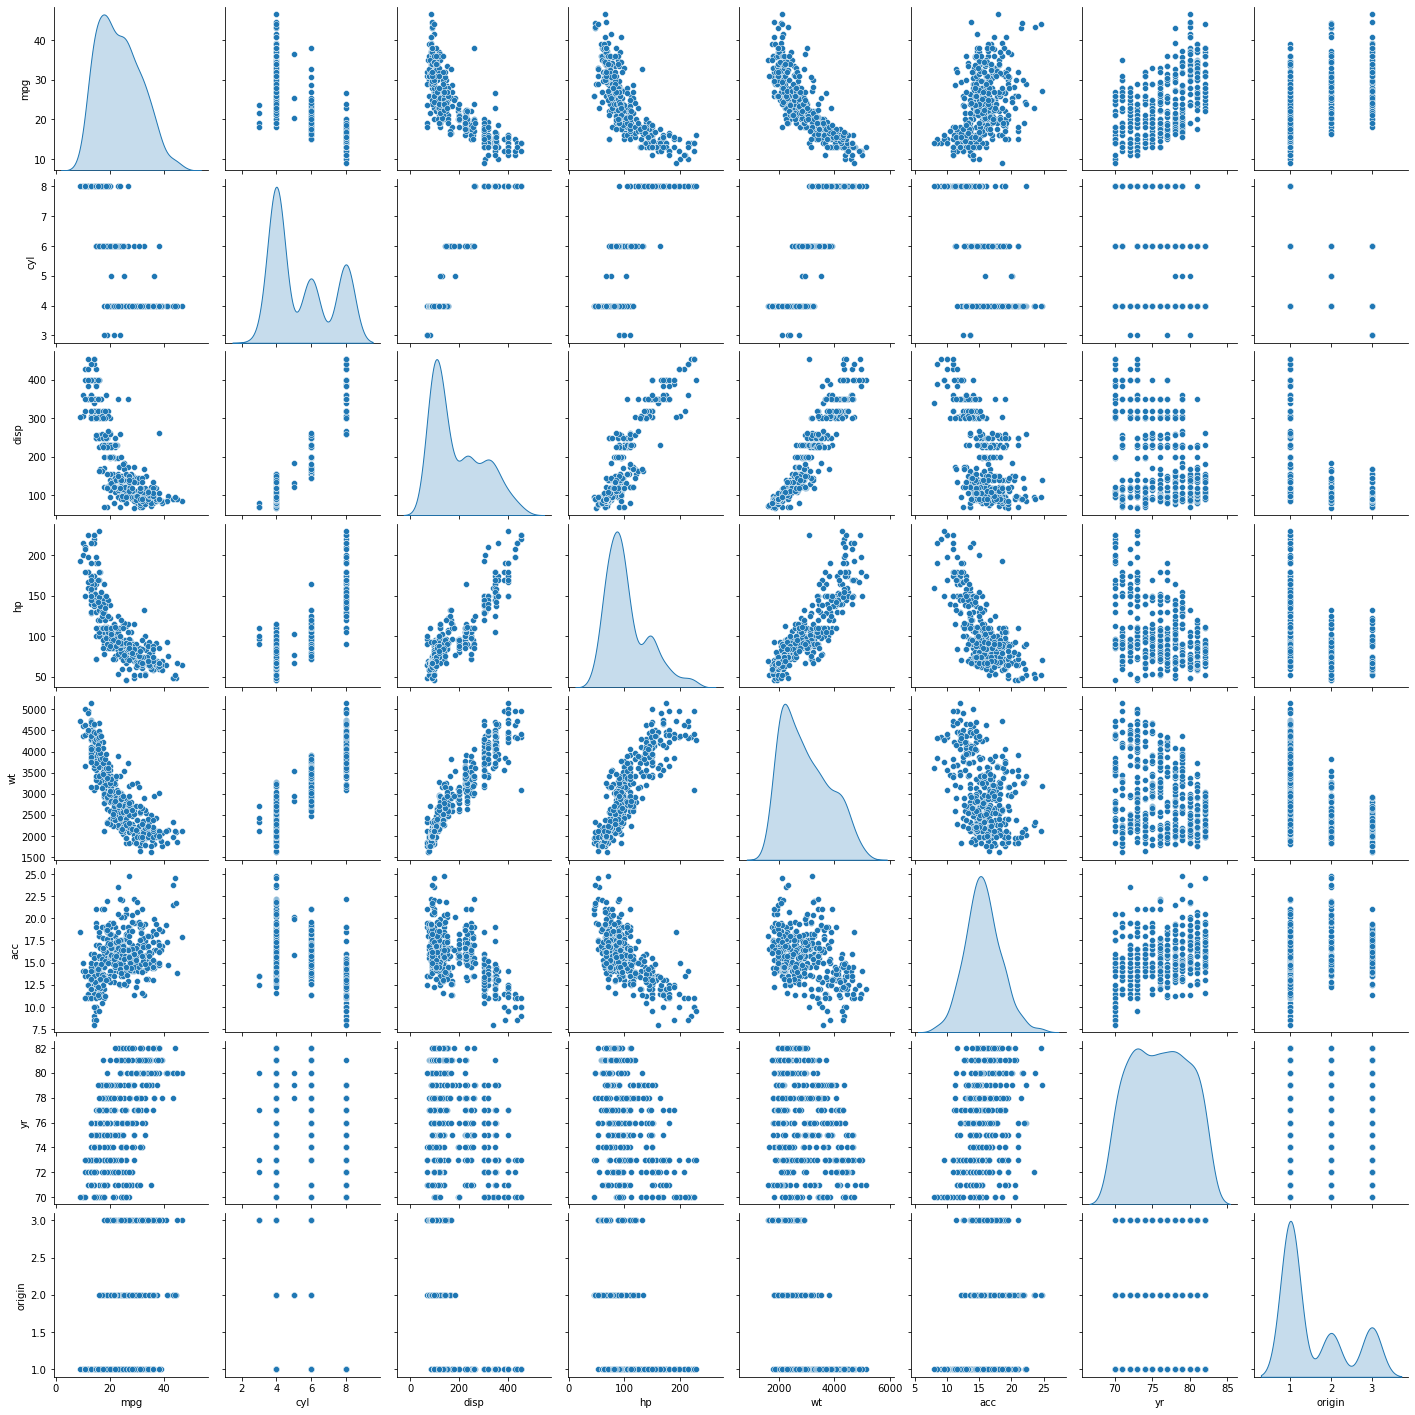

In [11]:
sns.pairplot(data, diag_kind='kde')

**Observation** -  It looks like we have good 2 or 3 clusters.

##### D. Visualize a scatterplot for ‘wt’ and ‘disp’. Datapoints should be distinguishable by ‘cyl’.

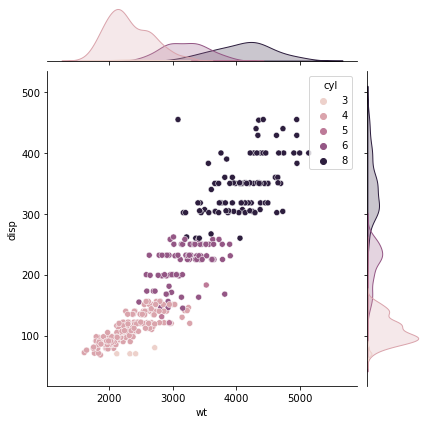

In [12]:
sns.jointplot(x='wt', y='disp', data=data, hue='cyl')

##### E. Share insights for Q2.d.

**Observation** -

a) Seems to be a **positive relationship** between the columns 'wt' and 'disp', because if the values of one variable increase so does the other.

b) The strength of the relationship appears to be **Moderate** because the points are **approx linear** in the graph.

c) **The Count of (8) & (4)** is more compared to other classes

d) Outliers are the data points that lie far away from the rest of the data values, in the graph **we can see outliers (very less)** in the scatterplot.

##### F. Visualize a scatterplot for ‘wt’ and ’mpg’. Datapoints should be distinguishable by ‘cyl’.

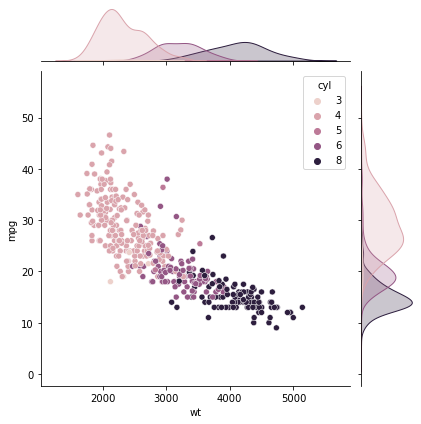

In [13]:
sns.jointplot(x='wt', y='mpg', data=data, hue='cyl')

##### G. Share insights for Q2.f.

**Observation** -

a) Seems to be a **Negative relationship** between the columns 'wt' and 'mpg', because if the values of one variable increase,  the other value decreases.

b) The strength of the relationship appears to be **Moderately strong** because the points are **almost linear** in the graph.

c) **The Count of (8) & (4)** is more compared to other classes

d) Outliers are the data points that lie far away from the rest of the data values, in the graph **there seems to be no outliers** in the scatterplot.

---------------------------

#### 3. Clustering:

##### A. Apply K-Means clustering for 2 to 10 clusters.

In [14]:
#we will remove 'car_name' column and keep it separately
car_names = pd.DataFrame(data[['car_name']])

data.drop('car_name', inplace=True, axis=1)

#Scaling
dataScaled=data.apply(zscore)

In [15]:
clusters=range(2,11)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(dataScaled)
    prediction=model.predict(dataScaled)
    meanDistortions.append(sum(np.min(cdist(dataScaled, model.cluster_centers_, 'euclidean'), axis=1)) / dataScaled.shape[0])

##### B. Plot a visual and find elbow point.

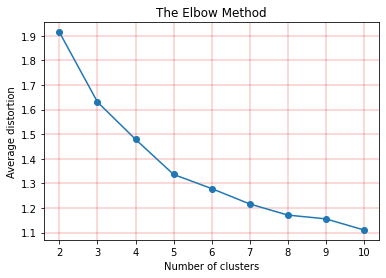

In [16]:
plt.grid(True, linewidth=0.3, color='#ee0000', linestyle='-')
plt.plot(clusters, meanDistortions, marker = "o")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average distortion')
plt.show()

##### C. On the above visual, highlight which are the possible Elbow points.

- The speed at which it is declining and a point where there is a sharp turn is at 3.

- Other elbow point could be at 5

##### D. Train a K-means clustering model once again on the optimal number of clusters.

###### Let us first start with K = 3

In [17]:
# Let us first start with K = 3
final_model=KMeans(3)
final_model.fit(dataScaled)
prediction=final_model.predict(dataScaled)

##### E. Add a new feature in the DataFrame which will have labels based upon cluster value.

In [18]:
#Append the prediction 
data['car_name'] = car_names
data['label'] = prediction
dataScaled['label'] = prediction
data.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name,label
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,1


In [19]:
data['label'].value_counts()

0    161
2    137
1    100
Name: label, dtype: int64

In [20]:
dataClust = data.groupby(['label'])
dataClust.mean()

,mpg,cyl,disp,hp,wt,acc,yr,origin
label,,,,,,,,
0,30.52795,4.068323,103.422360,77.372671,2234.720497,16.311801,77.155280,2.341615
1,14.71500,7.980000,346.370000,160.550000,4126.910000,12.721000,73.750000,1.000000
2,21.69562,5.240876,187.558394,94.897810,2990.861314,16.772263,76.313869,1.087591


##### F. Plot a visual and color the datapoints based upon clusters.

Text(0.5, 0.92, '3D plot of KMeans Clustering')

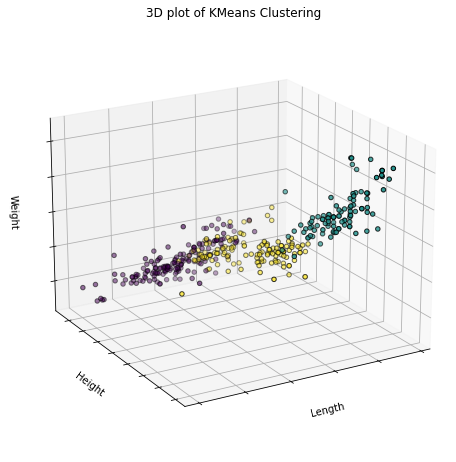

In [21]:
## 3D plots of clusters
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
final_model.fit(dataScaled)
labels = final_model.labels_
ax.scatter(dataScaled.iloc[:, 0], dataScaled.iloc[:, 2], dataScaled.iloc[:, 3],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

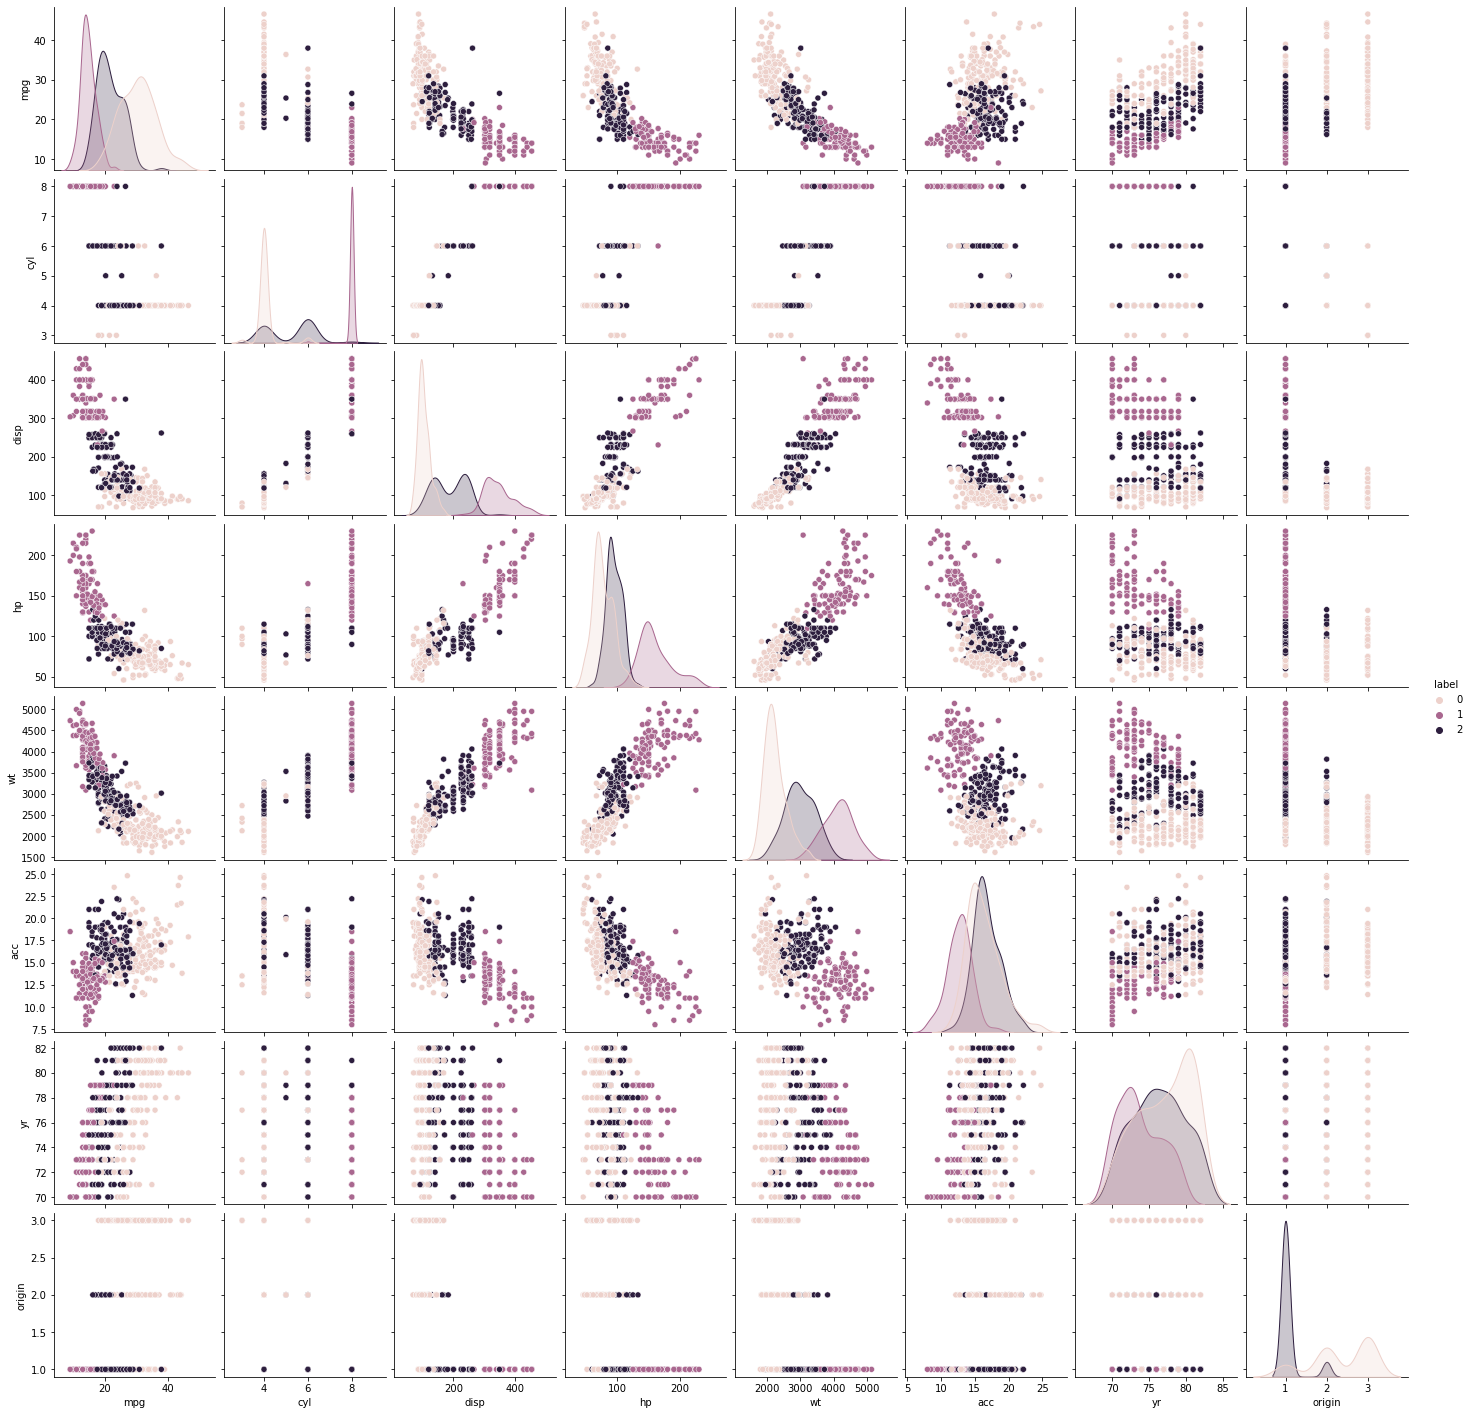

In [22]:
sns.pairplot(data, diag_kind='kde', hue='label')

##### G. Pass a new DataPoint and predict which cluster it belongs to.

In [23]:
dataScaled.head(250)

,mpg,cyl,disp,hp,wt,acc,yr,origin,label
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,1
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,1
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,1
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,1
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,1
...,...,...,...,...,...,...,...,...,...
245,1.612243,-0.856321,-0.916334,-1.003391,-1.383845,-0.424109,0.538847,-0.715145,0
246,1.189500,-0.856321,-1.108385,-1.370127,-1.165111,1.391285,0.538847,1.781589,0
247,2.034986,-0.856321,-1.041167,-0.898609,-1.064612,1.100822,0.538847,1.781589,0
248,1.612243,-0.856321,-0.983552,-1.160564,-1.383845,0.302049,0.538847,1.781589,0


In [24]:
#we will remove 'label' column
dataScaled.drop('label', inplace=True, axis=1)

In [25]:
model = KMeans(n_clusters = 3, random_state = 100)
model.fit(dataScaled)

KMeans(n_clusters=3, random_state=100)

Lets take example from each cluster from above dataframe to predict as a new data point
- Row 3 and 4 (Cluster A)
- Row 247 and 248 (Cluster B)
- Row 249 (Cluster C)

In [26]:
testdata= pd.DataFrame({"mpg":[-0.962647,-0.834543,2.034986,1.612243,-0.463041], 
                    'cyl':[1.498191,1.498191,-0.856321,-0.856321,1.498191],
                    'disp':[1.061796,1.042591,-1.041167,-0.983552,0.639283],
                    'hp':[1.197027,0.935072,-0.898609,-1.160564,0.149209],
                   'wt':[0.546923,0.565841,-1.064612,-1.383845,0.466524],
                   'acc':[-1.295498,-1.840117,1.100822,0.302049,-0.024722],
                   'yr':[-1.627426,-1.627426,0.538847,0.538847,0.538847],
                   'origin':[-0.715145,-0.715145,1.781589,1.781589,-0.715145]})

In [27]:
prediction=model.predict(testdata)

In [28]:
testdata['label'] = prediction
testdata

,mpg,cyl,disp,hp,wt,acc,yr,origin,label
0,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,2
1,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,2
2,2.034986,-0.856321,-1.041167,-0.898609,-1.064612,1.100822,0.538847,1.781589,0
3,1.612243,-0.856321,-0.983552,-1.160564,-1.383845,0.302049,0.538847,1.781589,0
4,-0.463041,1.498191,0.639283,0.149209,0.466524,-0.024722,0.538847,-0.715145,1


**Observation** - The datapoints are correctly mapped to the clusters as above

----------------------------------------------------

# Part B

• **DOMAIN**: Automobile
    
• **CONTEXT**: The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

• **DATA DESCRIPTION**: The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

• All the features are numeric i.e. geometric features extracted from the silhouette.

• **PROJECT OBJECTIVE**: Apply dimensionality reduction technique – PCA and train a model and compare relative results.

• **STEPS AND TASK**

#### 1. Data Understanding & Cleaning:

##### A. Read ‘vehicle.csv’ and save as DataFrame.

In [29]:
data = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/4. Unsupervised Learning/vehicle.csv')

print('Shape of the Dataframe', data.shape)

data.head()

Shape of the Dataframe (846, 19)


,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


##### B. Check percentage of missing values and impute with correct approach.

In [30]:
#creating a dataframe with sum of missing values
missing_val = pd.DataFrame(data.isnull().sum())

#Rename the column as missing_percentage.
missing_val = missing_val.rename(columns = {0: 'Missing_percentage'})

#Calculating in terms of percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(data))*100

#Arranging in descending order.
missing_val = missing_val.sort_values('Missing_percentage', ascending = False)

missing_val

,Missing_percentage
radius_ratio,0.709220
skewness_about,0.709220
circularity,0.591017
distance_circularity,0.472813
scaled_radius_of_gyration.1,0.472813
pr.axis_rectangularity,0.354610
scaled_variance,0.354610
pr.axis_aspect_ratio,0.236407
scaled_variance.1,0.236407
scaled_radius_of_gyration,0.236407


**Observation** - We will Impute the missing values since we have less datapoints and by dropping, we might miss on some important information

In [31]:
#Considering only numeric Columns
num_cols = data.drop('class', axis=1) 

# replacing the NaN values with median
num_cols = num_cols.apply(lambda x: x.fillna(x.median()),axis=0) 

#joining 'class' variable
data = num_cols.join(data['class'])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  846 non-null    float64
 2   distance_circularity         846 non-null    float64
 3   radius_ratio                 846 non-null    float64
 4   pr.axis_aspect_ratio         846 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                846 non-null    float64
 7   elongatedness                846 non-null    float64
 8   pr.axis_rectangularity       846 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              846 non-null    float64
 11  scaled_variance.1            846 non-null    float64
 12  scaled_radius_of_gyration    846 non-null    float64
 13  scaled_radius_of_gyr

##### C. Visualize a Pie-chart and print percentage of values for variable ‘class’.

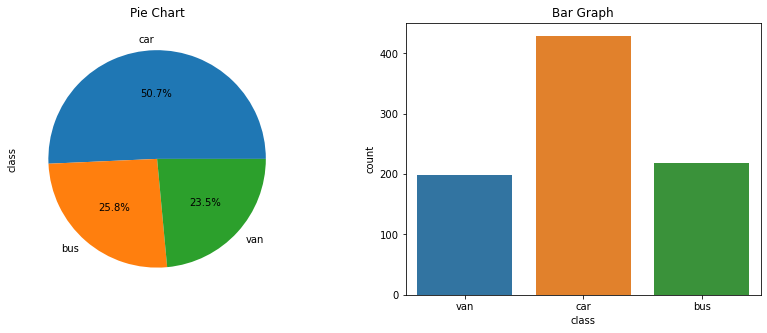

In [33]:
f,axes=plt.subplots(1,2,figsize=(14,5))
data['class'].value_counts().plot.pie(autopct='%1.1f%%',ax=axes[0])
sns.countplot('class',data=data,ax=axes[1])
axes[0].set_title('Pie Chart')
axes[1].set_title('Bar Graph')
plt.show()

##### D. Check for duplicate rows in the data and impute with correct approach.

In [34]:
data.duplicated().sum()

0

**Observation** - There are no duplicate values

----------------------

#### 2. Data Preparation

##### A. Split data into X and Y. [Train and Test optional]

In [35]:
#Replacing Target column into numbers

data.replace({"car": 0, "bus": 1, "van": 2}, inplace = True)

X = data.drop(['class'],axis=1)     
Y = data['class']

print(X.shape)
print(Y.shape)

(846, 18)
(846,)


##### B. Standardize the Data.

In [36]:
XScaled  = X.apply(zscore)

----------------------------

#### 3. Model Building:

##### A. Train a base Classification model using SVM.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(XScaled, Y, test_size=0.25, random_state=1)

# Shape of train and test data
print('shape of x_train:',x_train.shape)
print('shape of x_test:',x_test.shape)
print('shape of y_train:',y_train.shape)
print('shape of y_test:',y_test.shape)

shape of x_train: (634, 18)
shape of x_test: (212, 18)
shape of y_train: (634,)
shape of y_test: (212,)


In [38]:
sv = svm.SVC()
sv.fit(x_train , y_train)
sv_pred = sv.predict(x_test)

print('Accuracy on Training data:',sv.score(x_train, y_train))
print('Accuracy on Test data:',sv.score(x_test, y_test))

Accuracy on Training data: 0.973186119873817
Accuracy on Test data: 0.9716981132075472


**Observation** - Accuracy on Training and Test data are almost similar.

##### B. Print Classification metrics for train data.

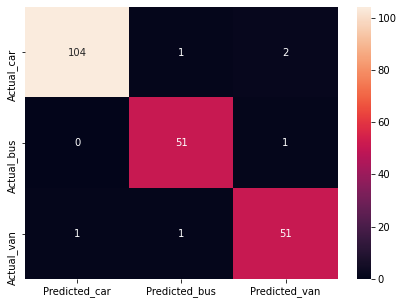

In [39]:
cm = metrics.confusion_matrix(y_test, sv_pred, labels=[0,1,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Actual_car","Actual_bus", "Actual_van"]],
                  columns = [i for i in ["Predicted_car","Predicted_bus", "Predicted_van"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')
plt.show()

In [40]:
print("Classification Report")
print(metrics.classification_report(y_test, sv_pred, labels=[0, 1, 2]))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       107
           1       0.96      0.98      0.97        52
           2       0.94      0.96      0.95        53

    accuracy                           0.97       212
   macro avg       0.97      0.97      0.97       212
weighted avg       0.97      0.97      0.97       212



**Observation** -

- Our model predicts *car* correctly most of the time.

- Misclassification of labels are more when predicting *van class*.

-------------------------------------------------------------------------------------------------------------------------

**The main diagonal** - (104, 51, 51) gives the correct predictions. 

**Class - car**

**The first row** (Actual_car) -  The model predicted 104 of these correctly and incorrectly predicted 1 as bus and 2 as van.

Looking at the **Predicted_car column**, of the 105 car predicted by the model (sum of Predicted_car column - 104+0+1),
- 104 were Actual_car.

- 1 were van incorrectly predicted to be car.

-------------------------------------------------------------------------------------------------------------------------------

**Class - bus**

**The second row** (Actual_bus) -  The model predicted 51 of these correctly and incorrectly predicted 1 as van.

Looking at the **Predicted_bus column**, of the 53 bus predicted by the model (sum of Predicted_bus column - 1+51+1),
- 51 were Actual_bus.

- 1 were car incorrectly predicted to be bus.

- 1 were van incorrectly predicted to be bus.

-------------------------------------------------------------------------------------------------------------------------------

**Class - van**

**The Third row** (Actual_van) -  The model predicted 51 of these correctly and incorrectly predicted 1 as car and 1 as bus.

Looking at the **Predicted_van column**, of the 54 van predicted by the model (sum of Predicted_Type_H column - 2+1+51),
- 51 were Actual_van.

- 2 were car incorrectly predicted to be van.

- 1 were bus incorrectly predicted to be van.

##### C. Apply PCA on the data with 10 components.

##### Covariance Matrix

In [41]:
covMatrix = np.cov(XScaled,rowvar=False)
print(covMatrix)

[[ 1.00118343  0.68569786  0.79086299  0.69055952  0.09164265  0.14842463
   0.81358214 -0.78968322  0.81465658  0.67694334  0.76297234  0.81497566
   0.58593517 -0.24988794  0.23635777  0.15720044  0.29889034  0.36598446]
 [ 0.68569786  1.00118343  0.79325751  0.6216467   0.15396023  0.25176438
   0.8489411  -0.82244387  0.84439802  0.96245572  0.79724837  0.83693508
   0.92691166  0.05200785  0.14436828 -0.01145212 -0.10455005  0.04640562]
 [ 0.79086299  0.79325751  1.00118343  0.76794246  0.15864319  0.26499957
   0.90614687 -0.9123854   0.89408198  0.77544391  0.86253904  0.88706577
   0.70660663 -0.22621115  0.1140589   0.26586088  0.14627113  0.33312625]
 [ 0.69055952  0.6216467   0.76794246  1.00118343  0.66423242  0.45058426
   0.73529816 -0.79041561  0.70922371  0.56962256  0.79435372  0.71928618
   0.53700678 -0.18061084  0.04877032  0.17394649  0.38266622  0.47186659]
 [ 0.09164265  0.15396023  0.15864319  0.66423242  1.00118343  0.64949139
   0.10385472 -0.18325156  0.07969

##### PCA

In [42]:
pca = PCA(n_components=10)
pca.fit(XScaled)

PCA(n_components=10)

###### The eigen Values

In [43]:
print(pca.explained_variance_)

[9.40460261 3.01492206 1.90352502 1.17993747 0.91726063 0.53999263
 0.35887012 0.22193246 0.1606086  0.09185722]


##### The eigen Vectors

In [44]:
print(pca.components_)

[[ 2.75283688e-01  2.93258469e-01  3.04609128e-01  2.67606877e-01
   8.05039890e-02  9.72756855e-02  3.17092750e-01 -3.14133155e-01
   3.13959064e-01  2.82830900e-01  3.09280359e-01  3.13788457e-01
   2.72047492e-01 -2.08137692e-02  4.14555082e-02  5.82250207e-02
   3.02795063e-02  7.41453913e-02]
 [-1.26953763e-01  1.25576727e-01 -7.29516436e-02 -1.89634378e-01
  -1.22174860e-01  1.07482875e-02  4.81181371e-02  1.27498515e-02
   5.99352482e-02  1.16220532e-01  6.22806229e-02  5.37843596e-02
   2.09233172e-01  4.88525148e-01 -5.50899716e-02 -1.24085090e-01
  -5.40914775e-01 -5.40354258e-01]
 [-1.19922479e-01 -2.48205467e-02 -5.60143254e-02  2.75074211e-01
   6.42012966e-01  5.91801304e-01 -9.76283108e-02  5.76484384e-02
  -1.09512416e-01 -1.70641987e-02  5.63239801e-02 -1.08840729e-01
  -3.14636493e-02  2.86277015e-01 -1.15679354e-01 -7.52828901e-02
   8.73592034e-03  3.95242743e-02]
 [ 7.83843562e-02  1.87337408e-01 -7.12008427e-02 -4.26053415e-02
   3.27257119e-02  3.14147277e-02 -9.

##### Percentage of variation explained by each eigen Vector

In [45]:
print(pca.explained_variance_ratio_)

[0.52186034 0.16729768 0.10562639 0.0654746  0.05089869 0.02996413
 0.01991366 0.01231501 0.00891215 0.00509715]


###### Plot the same

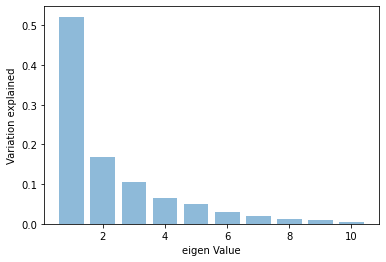

In [46]:
plt.bar(list(range(1,11)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

##### D. Visualize Cumulative Variance Explained with Number of Components.

##### E. Draw a horizontal line on the above plot to highlight the threshold of 90%.

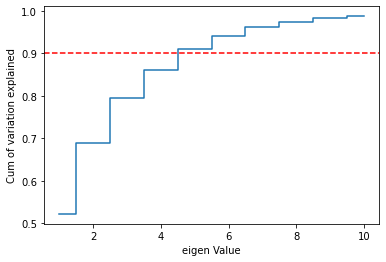

In [47]:
plt.step(list(range(1,11)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

**Observation** - With 5 variables we can explain over 90% of the variation in the data.

##### F. Apply PCA on the data. This time Select Minimum Components with 90% or above variance explained.

In [48]:
#PCA
pca2 = PCA(n_components=5)
pca2.fit(XScaled)

#The eigen Values
print(pca2.explained_variance_)

print()

#The eigen Vectors
print(pca2.components_)

print()

#Percentage of variation explained by each eigen Vector
print(pca2.explained_variance_ratio_)

XScaled_pca = pca2.transform(XScaled)

[9.40460261 3.01492206 1.90352502 1.17993747 0.91726063]

[[ 2.75283688e-01  2.93258469e-01  3.04609128e-01  2.67606877e-01
   8.05039890e-02  9.72756855e-02  3.17092750e-01 -3.14133155e-01
   3.13959064e-01  2.82830900e-01  3.09280359e-01  3.13788457e-01
   2.72047492e-01 -2.08137692e-02  4.14555082e-02  5.82250207e-02
   3.02795063e-02  7.41453913e-02]
 [-1.26953763e-01  1.25576727e-01 -7.29516436e-02 -1.89634378e-01
  -1.22174860e-01  1.07482875e-02  4.81181371e-02  1.27498515e-02
   5.99352482e-02  1.16220532e-01  6.22806229e-02  5.37843596e-02
   2.09233172e-01  4.88525148e-01 -5.50899716e-02 -1.24085090e-01
  -5.40914775e-01 -5.40354258e-01]
 [-1.19922479e-01 -2.48205467e-02 -5.60143254e-02  2.75074211e-01
   6.42012966e-01  5.91801304e-01 -9.76283108e-02  5.76484384e-02
  -1.09512416e-01 -1.70641987e-02  5.63239800e-02 -1.08840729e-01
  -3.14636493e-02  2.86277015e-01 -1.15679354e-01 -7.52828901e-02
   8.73592036e-03  3.95242743e-02]
 [ 7.83843563e-02  1.87337408e-01 -7.12008428

In [49]:
# Percentage of variance explained by 5 Principle components
sum(pca2.explained_variance_ratio_*100)

91.1157695244908

##### G. Train SVM model on components selected from above step.

In [50]:
# split the transformed pca data
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(XScaled_pca, Y, test_size = 0.25, random_state = 1)

# Shape of train and test data
print('shape of pca_x_train:',pca_x_train.shape)
print('shape of pca_x_test:',pca_x_test.shape)
print('shape of pca_y_train:',pca_y_train.shape)
print('shape of pca_y_test:',pca_y_test.shape)

shape of pca_x_train: (634, 5)
shape of pca_x_test: (212, 5)
shape of pca_y_train: (634,)
shape of pca_y_test: (212,)


In [51]:
sv_pca = svm.SVC()
sv_pca.fit(pca_x_train , pca_y_train)
sv_pca_pred = sv_pca.predict(pca_x_test)

print('Accuracy on Training data:',sv_pca.score(pca_x_train, pca_y_train))
print('Accuracy on Test data:',sv_pca.score(pca_x_test, pca_y_test))

Accuracy on Training data: 0.7917981072555205
Accuracy on Test data: 0.7830188679245284


**Observation** - Accuracy on Training and Test data are almost similar.

##### H. Print Classification metrics for train data of above model and share insights.

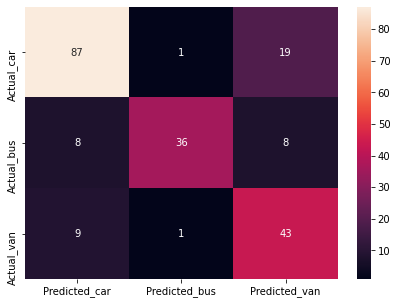

In [52]:
cm = metrics.confusion_matrix(pca_y_test, sv_pca_pred, labels=[0,1,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Actual_car","Actual_bus", "Actual_van"]],
                  columns = [i for i in ["Predicted_car","Predicted_bus", "Predicted_van"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')
plt.show()

In [53]:
print("Classification Report")
print(metrics.classification_report(pca_y_test, sv_pca_pred, labels=[0, 1, 2]))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       107
           1       0.95      0.69      0.80        52
           2       0.61      0.81      0.70        53

    accuracy                           0.78       212
   macro avg       0.80      0.77      0.77       212
weighted avg       0.81      0.78      0.79       212



**Observation** -

- Our model predicts *bus* correctly most of the time.

- Misclassification of labels are more when predicting *van class*.

-------------------------------------------------------------------------------------------------------------------------

**The main diagonal** - (87, 36, 43) gives the correct predictions. 

**Class - car**

**The first row** (Actual_car) -  The model predicted 87 of these correctly and incorrectly predicted 1 as bus and 19 as van.

Looking at the **Predicted_car column**, of the 104 car predicted by the model (sum of Predicted_car column - 87+8+9),
- 87 were Actual_car.
- 8 were bus incorrectly predicted to be car.
- 9 were van incorrectly predicted to be car.

-------------------------------------------------------------------------------------------------------------------------------

**Class - bus**

**The second row** (Actual_bus) -  The model predicted 36 of these correctly and incorrectly predicted 8 as car and 8 as van.

Looking at the **Predicted_bus column**, of the 38 bus predicted by the model (sum of Predicted_bus column - 1+36+1),
- 36 were Actual_bus.

- 1 were car incorrectly predicted to be bus.

- 1 were van incorrectly predicted to be bus.

-------------------------------------------------------------------------------------------------------------------------------

**Class - van**

**The Third row** (Actual_van) -  The model predicted 43 of these correctly and incorrectly predicted 9 as car and 1 as bus.

Looking at the **Predicted_van column**, of the 70 van predicted by the model (sum of Predicted_Type_H column - 19+8+43),
- 43 were Actual_van.

- 19 were car incorrectly predicted to be van.

- 8 were bus incorrectly predicted to be van.

---------------------------

#### 4. Performance Improvement:

##### A. Train another SVM on the components out of PCA. Tune the parameters to improve performance.

In [54]:
param_grid = {'C': [0.01, 0.05, 0.5, 1], 'kernel': ['linear', 'rbf']}
skf = StratifiedKFold(n_splits = 10)
grid = GridSearchCV(SVC(),param_grid, n_jobs = -1, cv = skf)
grid.fit(pca_x_train,pca_y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.5, 1],
                         'kernel': ['linear', 'rbf']})

In [55]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# print best score after hyper-parameter tuning
print('Best Score is: ', grid.best_score_)

{'C': 1, 'kernel': 'rbf'}
SVC(C=1)
Best Score is:  0.7585813492063492


In [56]:
# use the best hyperparameters
#Train a Supervised Learning Classification base model - SVM
sv_hp = svm.SVC(C=1,kernel='rbf')
sv_hp.fit(pca_x_train, pca_y_train)
sv_hp_pred = sv_hp.predict(pca_x_test)

print('Accuracy on Training data:',sv_hp.score(pca_x_train, pca_y_train))
print('Accuracy on Test data:',sv_hp.score(pca_x_test, pca_y_test))


Accuracy on Training data: 0.7917981072555205
Accuracy on Test data: 0.7830188679245284


##### B. Share best Parameters observed from above step.

- Best Hyper Parameters are:  {'C': 1, 'kernel': 'rbf'}
- Best Score is:  0.7585813492063492

##### C. Print Classification metrics for train data of above model and share relative improvement in performance in all the models along with insights.

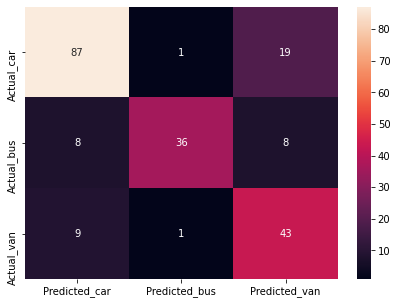

In [57]:
cm_s = metrics.confusion_matrix(pca_y_test, sv_hp_pred, labels=[0,1,2])

df_cm_s = pd.DataFrame(cm_s, index = [i for i in ["Actual_car","Actual_bus", "Actual_van"]],
                  columns = [i for i in ["Predicted_car","Predicted_bus", "Predicted_van"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm_s, annot=True ,fmt='g')
plt.show()

In [58]:
print("Classification Report")
print(metrics.classification_report(pca_y_test, sv_hp_pred, labels=[0, 1, 2]))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       107
           1       0.95      0.69      0.80        52
           2       0.61      0.81      0.70        53

    accuracy                           0.78       212
   macro avg       0.80      0.77      0.77       212
weighted avg       0.81      0.78      0.79       212



**Observation**

 **Accuracy** - 
- a) **SVM Model without PCA and tuned Hyperparameter** - 97.17%
- b) **SVM Model after considering 5 principle components** - 78.30%
- c) **SVM Model with 5 principle components and tuned Hyperparameter** - 78.30%

Our model performed well without 5 principle components and tuned Hyperparameter.

----------------------------------------------------------------------------------------------------------------------
 **Precision** - 
- a) **SVM Model without PCA and Hyperparameter** - car:0.99, bus:0.96, van:0.94
- b) **SVM Model after considering 5 principle components** - car:0.84, bus:0.95, van:0.61
- c) **SVM Model with 5 principle components and tuned Hyperparameter** - car:0.84, bus:0.95, van:0.61

Our model perfomed well without 5 principle components and tuned Hyperparameter.

--------------------------------------------------------------------------------------------------------------------
 **Recall** -
- a) **SVM Model without PCA and Hyperparameter** - car:0.97, bus:0.98, van:0.96
- b) **SVM Model after considering 5 principle components** - car:0.81, bus:0.69, van:0.81
- c) **SVM Model with 5 principle components and tuned Hyperparameter** - car:0.81, bus:0.69, van:0.81

Our model performed well without 5 principle components and tuned Hyperparameter.

-------------------------------------------------------------------------------------------------------------------------

**Conclusion** - 
- Our model performed well without 5 principle components and tuned Hyperparameter.
- Our model performs in similar way in b) and c) w.r.t to Accuracy, Precision and Recall. 
- i.e, tuning the parameters does not improve the performance of the model.

-----------------------

#### 5. Data Understanding & Cleaning:

##### A. Explain pre-requisite/assumptions of PCA.

- **Linearity**: It assumes that the relationship between the variables are linearly related.
- The reason for this assumption is that a PCA is based on Pearson correlation coefficients, and as such, there needs to be a linear relationship between the variables.

- **Outliers**: PCA is sensitive to outliers, they should be removed.

- **Sample size**: Ideally, there should be 150+ cases and there should be ratio of at least five cases for each variable.

- **Correlations**: There should be some correlation among the factors to be considered for PCA.
- Pearson correlation coefficient framework led to the origin of PCA. Hence it assumes that the principal component with high variance must be paid attention and the PCs with lower variance are disregarded as noise

- **Interval-level measurement** - All variables should be assessed on an interval or ratio level of measurement.


##### B. Explain advantages and limitations of PCA.

###### Advantages

- **Removes Correlated Features**: PCA is used to transform (data reduction technique) large number of correlated variables into a much smaller number of uncorrelated variables (principal components).
- **Improves Algorithm Performance**: By getting rid of correlated variables which don’t contribute in any decision making,the training time of the algorithms reduces significantly with less number of features. 
- **Reduces Overfitting**: - Overfitting mainly occurs when there are too many variables in the dataset. So, PCA helps in overcoming the overfitting issue by reducing the number of features.
- **Improves Visualization**: It is very hard to visualize and understand the data in high dimensions. PCA transforms a high dimensional data to low dimensional data, so that it can be visualized easily.
- **Noise filtering**: Reduction of noise since the maximum variation basis is chosen and so the small variations in the background are ignored automatically.

###### Limitations

- It is **not suitable for small data sets** (Generally, data set should have more than 30 rows)
- Data needs to be **standardized** before implementing PCA else it becomes difficult to identify optimal principal components.
- It is difficult to **evaluate the covariance** in a proper way.
- Though PCA covers maximum variance amid data features, sometimes it may **skip a bit of information** in comparison to the actual list of features.
- Implementing PCA over datasets leads to transforming actual features in principal components that are linear combinations of actual features, therefore **principle components are difficult to read or interpret as compared to actual features**.
- Although Principal Components try to cover maximum variance among the features in a dataset, **if we don’t select the number of Principal Components with care, it may miss some information as compared to the original list of features**.

-------------------------------